In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [2]:
# Synth Noise - Good vs Bad Noise

In [3]:
# Good Noise

import numpy as np
from src.utils.data import add_noise

def make_blob_and_noise_dist_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[-20, -20], [20, -20], [-20, 20], [20, 20]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    X, l = add_noise(X, l, n_noise, 2, 0.5, border=5 + 2 * (n_noise / n_samples) * (np.max(X) - np.min(X)))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
noises = np.arange(0, 801, 80)
good_synth_noise_datasets = [
    [make_blob_and_noise_dist_uniform(200, n_noise=n_noise, seed=seed) for seed in random_seeds] for n_noise in noises
]

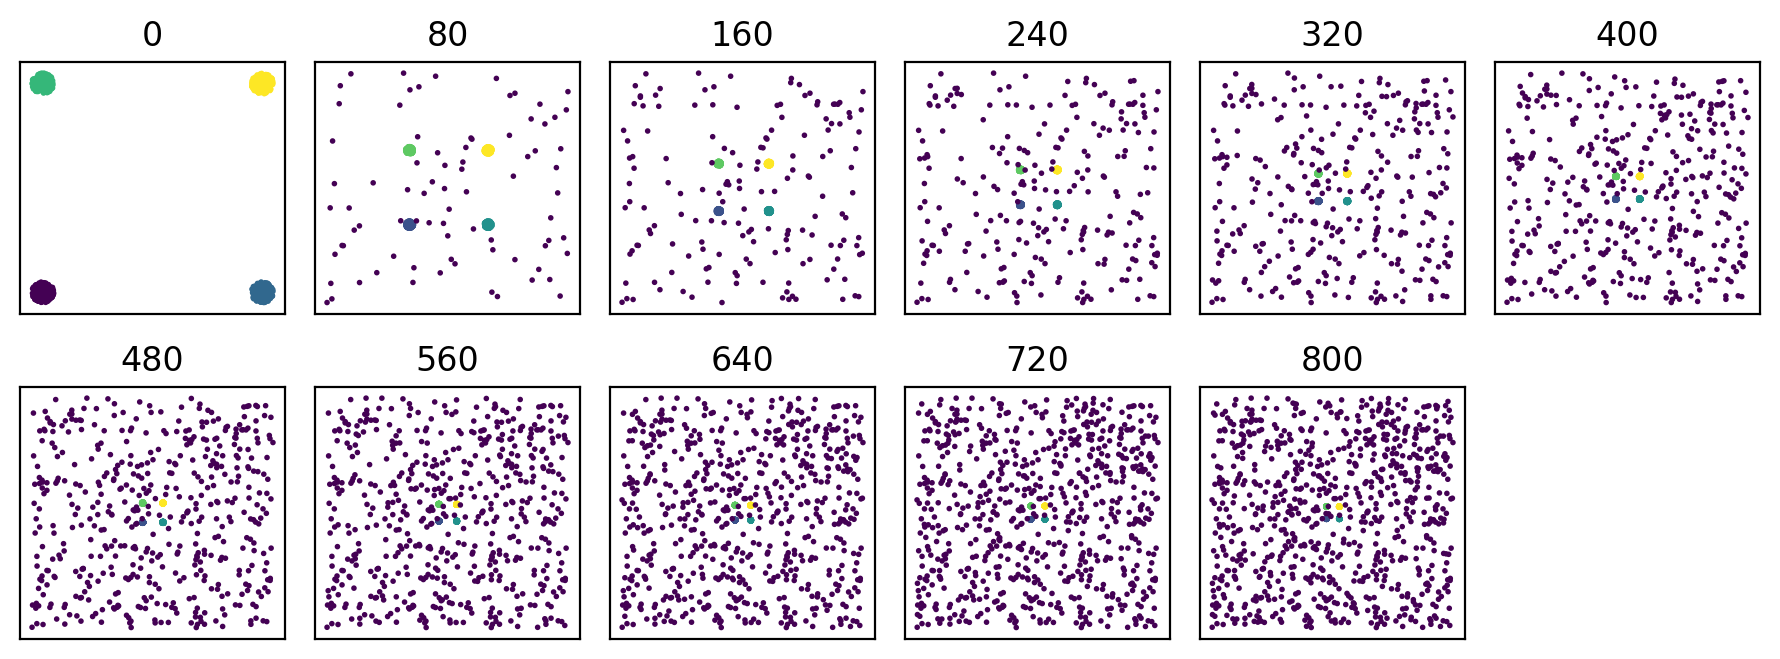

In [4]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets
from src.utils.data import sample_datasets


fig = plot_datasets(good_synth_noise_datasets, noises, n_cols=6, figsize=1.5)

# axes = fig.get_axes()
# for ax in axes:
#     ax.set_ylim(-20, 20)
#     ax.set_xlim(-20, 20)
#     ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/good_noise_data.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [67]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, SELECTED_METRICS


eval_results = cache(
    "good_synth_noise",
    calc_eval_measures_for_multiple_datasets,
    [good_synth_noise_datasets, noises],
    recalc=False,
)

# selected_metrics = ["DISCO", "DBCV", "LCCV", "CVNN"]

df = create_and_rescale_df(eval_results)

In [71]:
import pandas as pd

df_no_noise = pd.DataFrame(df.loc[df.dataset == 0].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "no noise"})
df_good_noise = pd.DataFrame(df.loc[df.dataset == 800].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "noise"})
df_merged = df_no_noise.merge(df_good_noise, left_index=True, right_index=True)
df_merged.round(2)

,no noise,noise
measure,,
DISCO,0.99,0.98
DBCV,1.00,0.50
DCSI,1.00,1.00
LCCV,0.62,0.51
VIASCKDE,0.20,0.07
CVDD,0.82,0.01
CDBW,0.95,0.95
CVNN,0.35,0.35
SILHOUETTE,0.95,0.30


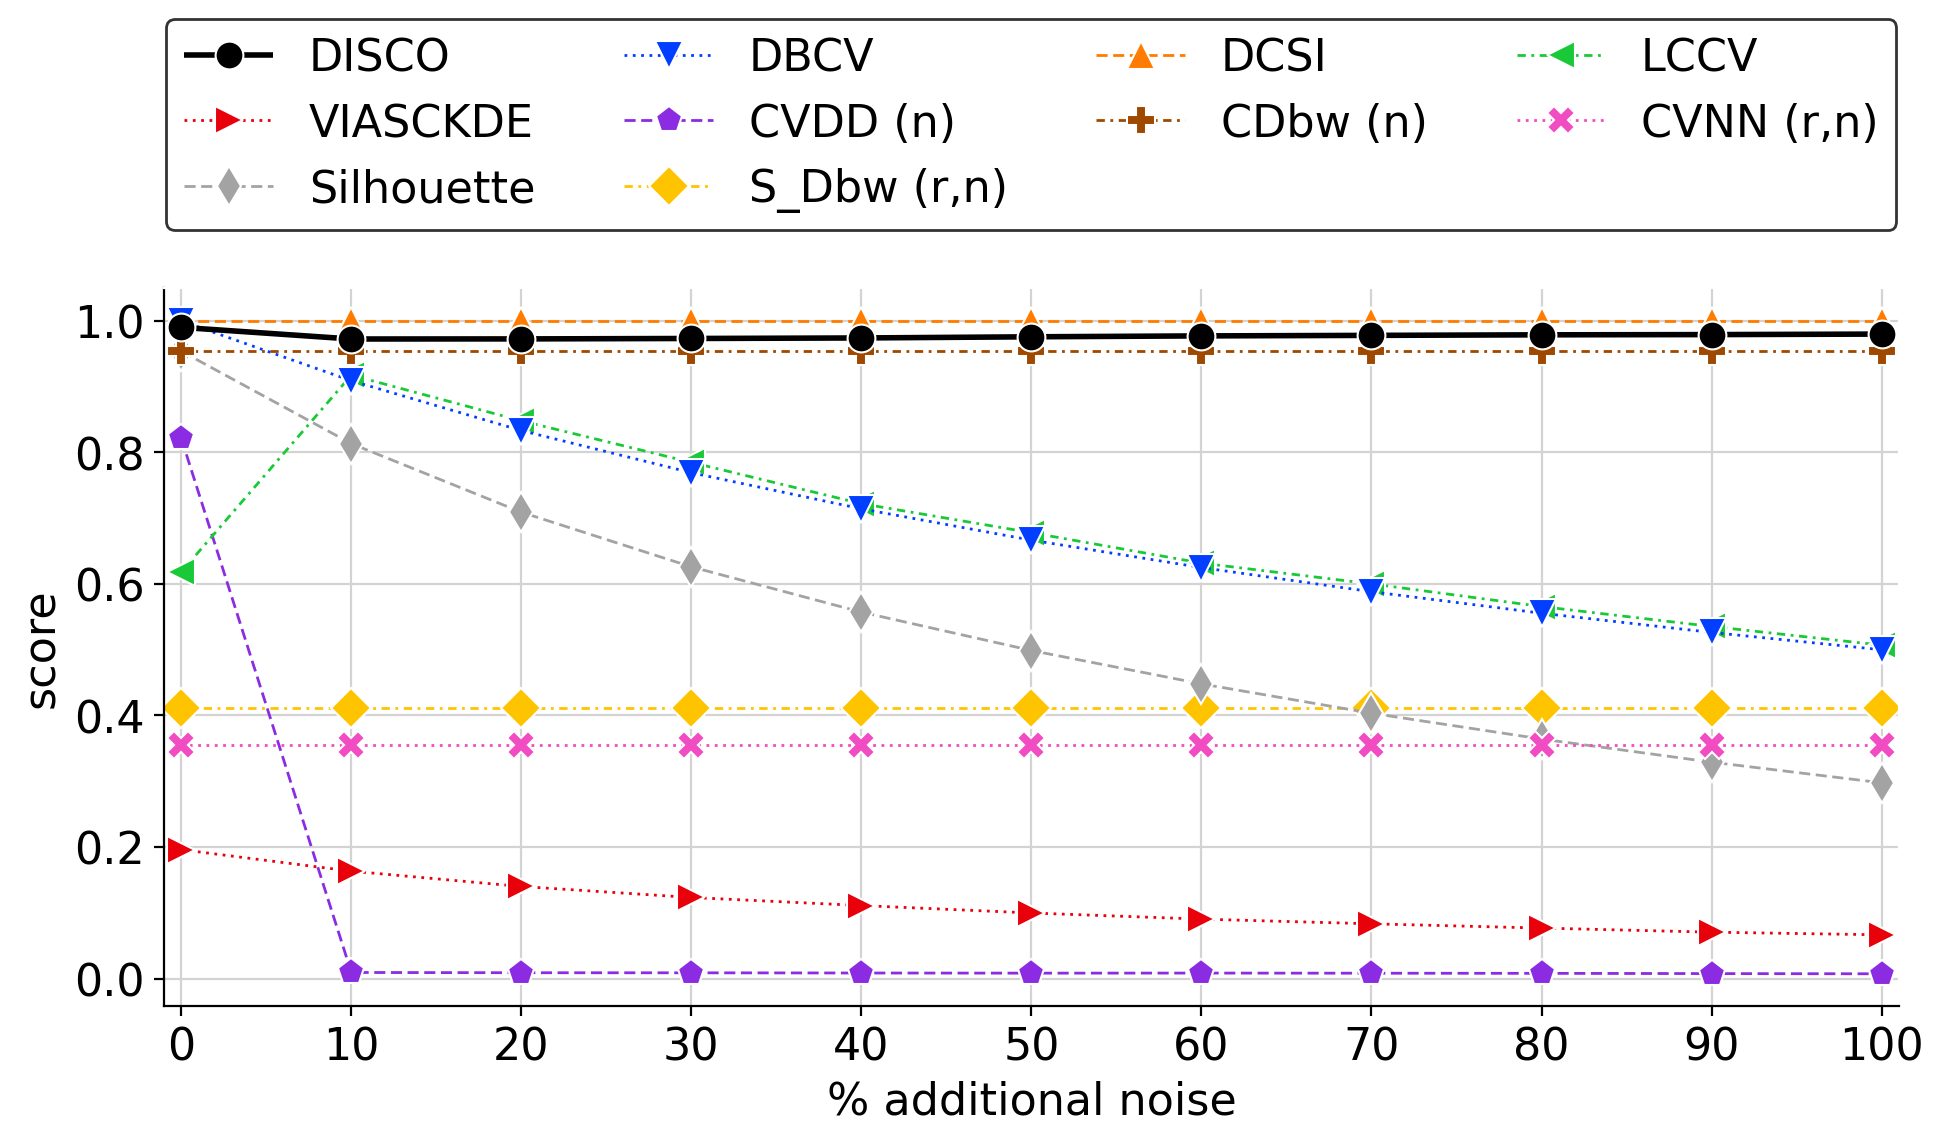

In [6]:
from src.utils.plots import plot_lineplot, GRAY
import seaborn as sns

eps = 8
x_range = noises[0] - eps, noises[-1] + eps

fig = plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    x_label="% additional noise",
    y_label="score",
    x_range=x_range,
    y_range=(None, None),
    # figsize=(10, 4),
    # palette=["black"] + list(np.array(sns.color_palette("bright"))[[0, 2, 6]]) + [GRAY],
    # markers=["o"] + list(np.array(["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"])[[0, 2, 6]]),
    # dashes=[(1, 0)] + list(np.array([(1, 2), (4, 2), (3, 2, 1, 2)], dtype=object)[[0, 2, (6 % 3)]]),
    # sizes=[3] + [2] * 10,
    errorbar=None,
    markersize=10,
)
ax = fig.gca()
ax.set_xticks(noises)
ax.set_xticklabels(np.arange(0, 101, 10))
plt.savefig("imgs/good_synth_noise.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [7]:
# Bad Noise

import numpy as np
from src.utils.data import add_noise

def make_blob_and_noise_dist_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[-20, -20], [20, -20], [-20, 20], [20, 20]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    n_noise = n_noise // len(centers)
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_noise:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_noise * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_noise - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([-1] * len(X_i))))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
noises = np.arange(0, 801, 80)
bad_synth_noise_datasets = [
    [make_blob_and_noise_dist_uniform(200, n_noise=n_noise, seed=seed) for seed in random_seeds] for n_noise in noises
]

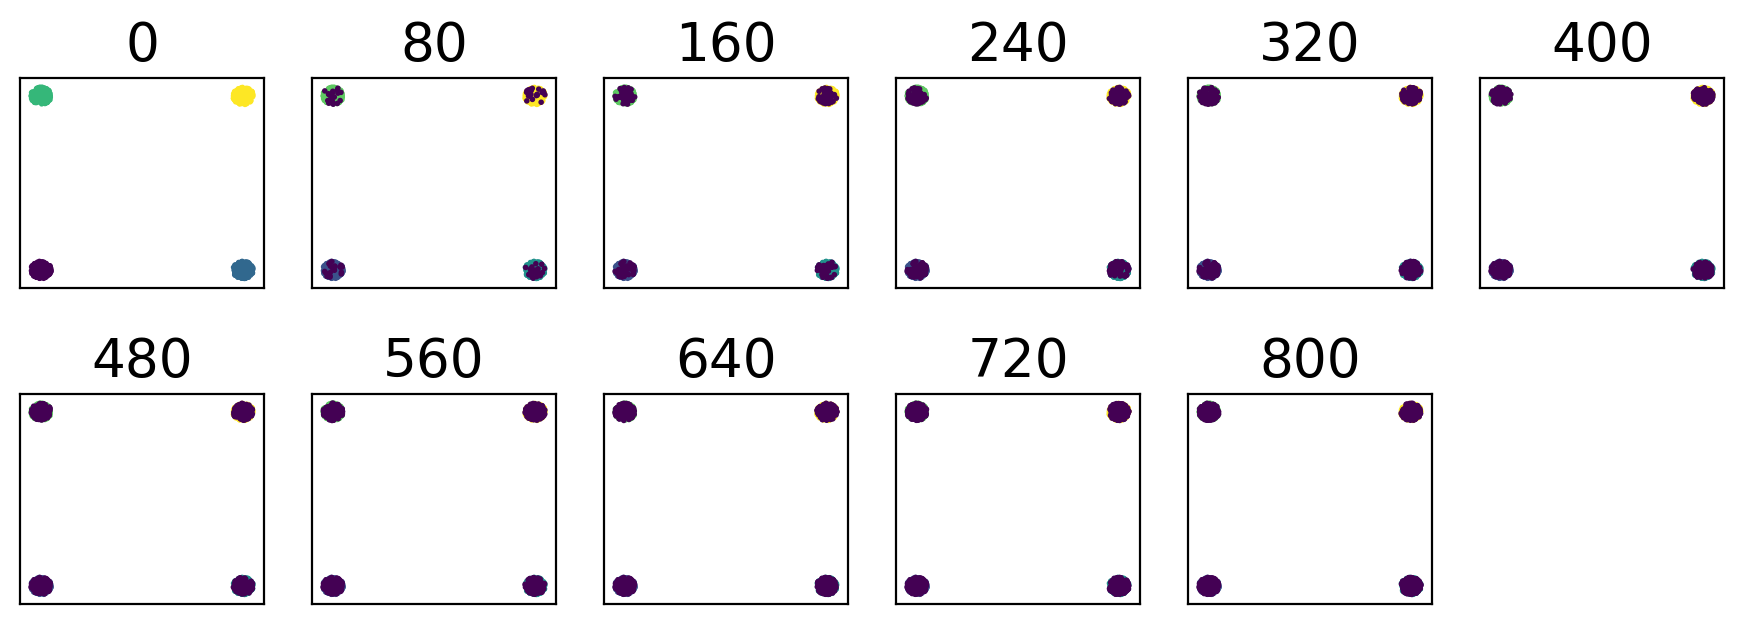

In [8]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets
from src.utils.data import sample_datasets


fig = plot_datasets(bad_synth_noise_datasets, noises, n_cols=6, figsize=1.5)

# axes = fig.get_axes()
# for ax in axes:
#     ax.set_ylim(-20, 20)
#     ax.set_xlim(-20, 20)
#     ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/bad_noise_data.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [60]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, SELECTED_METRICS


eval_results = cache(
    "bad_synth_noise",
    calc_eval_measures_for_multiple_datasets,
    [bad_synth_noise_datasets, noises],
    recalc=False,
)

# selected_metrics = ["DISCO", "DBCV", "LCCV", "CVNN"]

df = create_and_rescale_df(eval_results)

In [66]:
import pandas as pd

df_no_noise = pd.DataFrame(df.loc[df.dataset == 0].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "no noise"})
df_bad_noise = pd.DataFrame(df.loc[df.dataset == 800].groupby(["measure"])["value"].mean()).reindex(SELECTED_METRICS).rename(columns={"value": "noise"})
df_merged = df_no_noise.merge(df_bad_noise, left_index=True, right_index=True)
df_merged.round(2)

,no noise,noise
measure,,
DISCO,0.99,0.23
DBCV,1.00,0.50
DCSI,1.00,1.00
LCCV,0.62,0.27
VIASCKDE,0.20,-0.00
CVDD,0.78,0.73
CDBW,0.95,0.95
CVNN,0.14,0.73
SILHOUETTE,0.95,-0.00


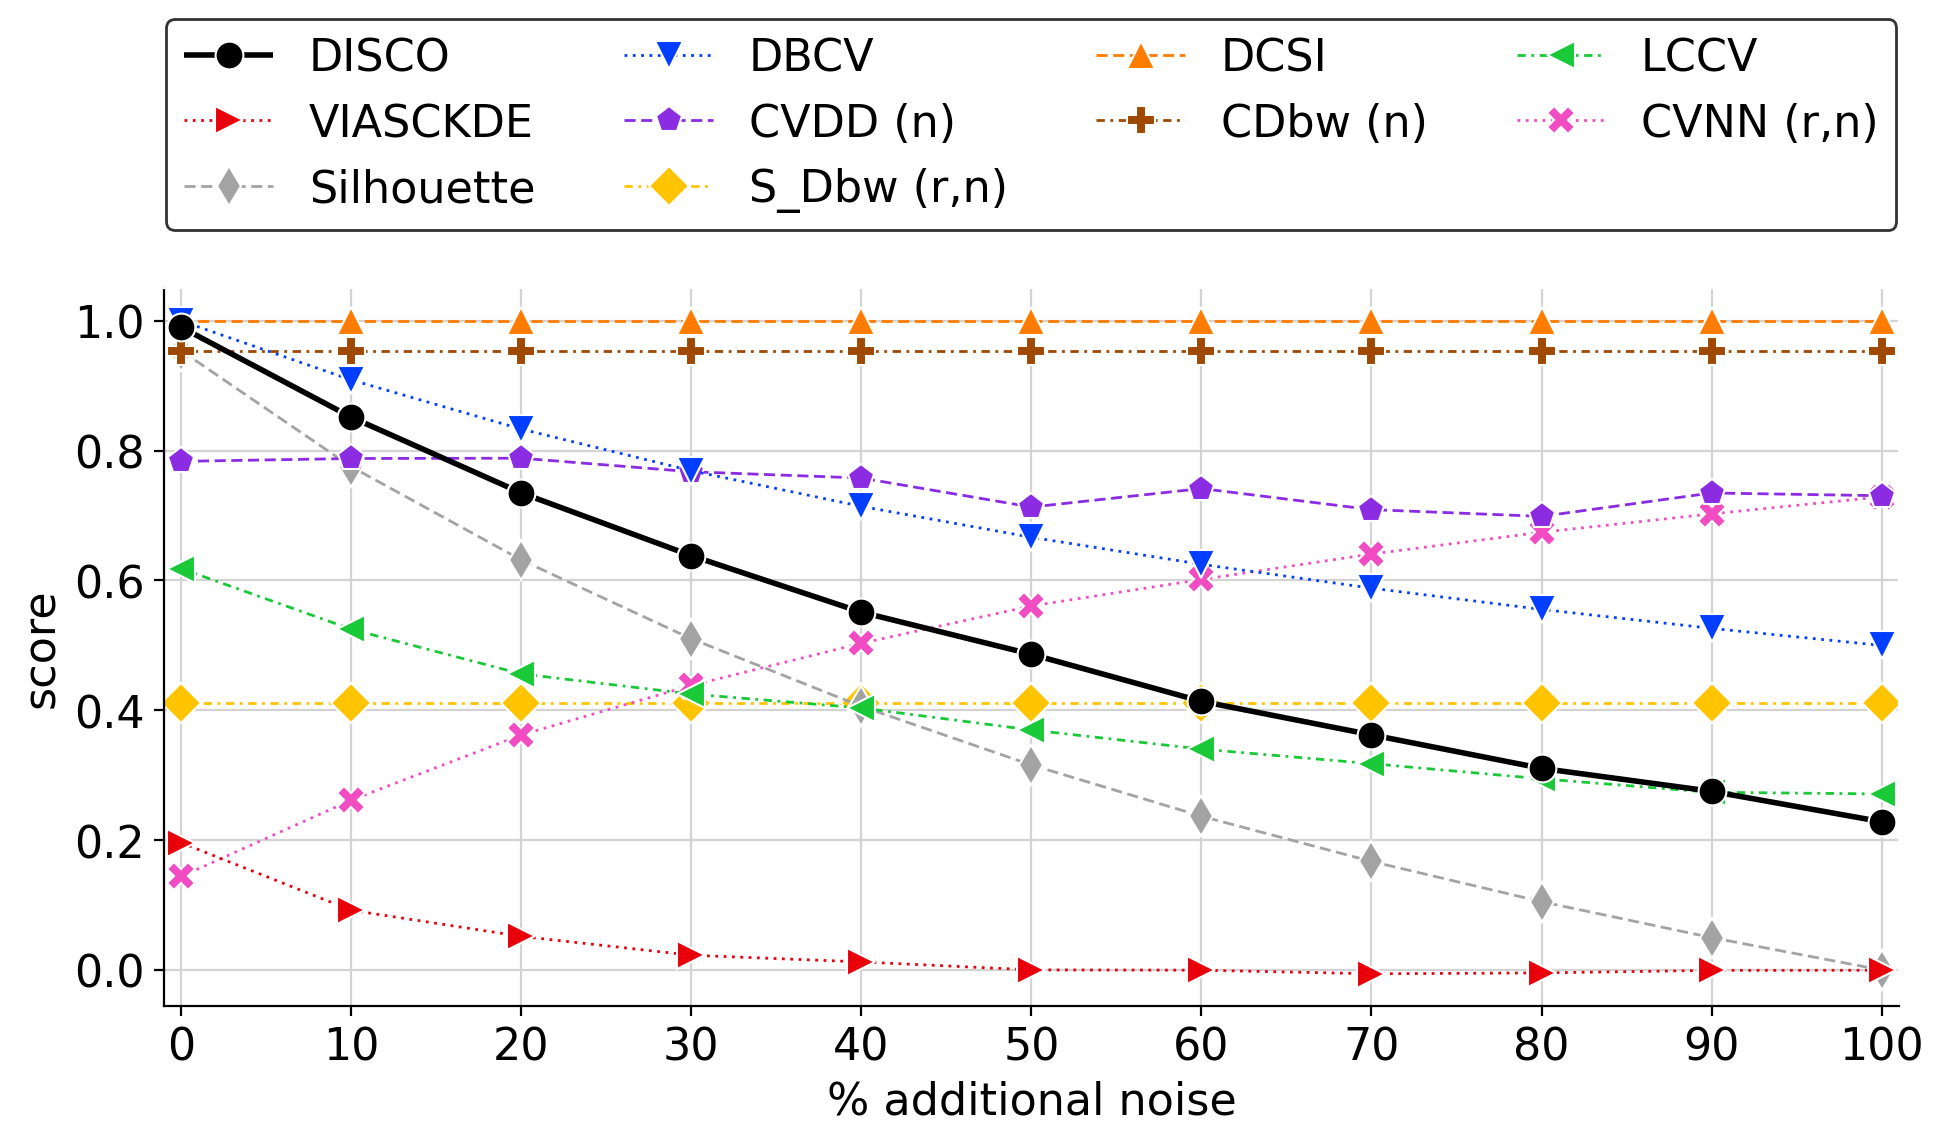

In [10]:
from src.utils.plots import plot_lineplot, GRAY
import seaborn as sns

eps = 8
x_range = noises[0] - eps, noises[-1] + eps

fig = plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    x_label="% additional noise",
    y_label="score",
    x_range=x_range,
    y_range=(None, None),
    # figsize=(10, 4),
    # palette=["black"] + list(np.array(sns.color_palette("bright"))[[0, 2, 6]]) + [GRAY],
    # markers=["o"] + list(np.array(["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"])[[0, 2, 6]]),
    # dashes=[(1, 0)] + list(np.array([(1, 2), (4, 2), (3, 2, 1, 2)], dtype=object)[[0, 2, (6 % 3)]]),
    # sizes=[3] + [2] * 10,
    errorbar=None,
    markersize=10,
)
ax = fig.gca()
ax.set_xticks(noises)
ax.set_xticklabels(np.arange(0, 101, 10))
plt.savefig("imgs/bad_synth_noise.pdf", format="pdf", bbox_inches="tight", pad_inches=0)